In [13]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pynumdiff

#plots
import figurefirst
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/'

In [3]:
def boxplotfill(ax):
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('None')

In [4]:
def set_grid_false(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.grid(False)

In [5]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
#     osm.encounter_frequency(df,index,fdf)
#     osm.mean_avg(df,index,fdf)

In [6]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches


def add_label_band(ax, top, bottom, label, *, spine_pos=-0.05, tip_pos=-0.02):
    """
    Helper function to add bracket around y-tick labels.

    Parameters
    ----------
    ax : matplotlib.Axes
        The axes to add the bracket to

    top, bottom : floats
        The positions in *data* space to bracket on the y-axis

    label : str
        The label to add to the bracket

    spine_pos, tip_pos : float, optional
        The position in *axes fraction* of the spine and tips of the bracket.
        These will typically be negative

    Returns
    -------
    bracket : matplotlib.patches.PathPatch
        The "bracket" Aritst.  Modify this Artist to change the color etc of
        the bracket from the defaults.

    txt : matplotlib.text.Text
        The label Artist.  Modify this to change the color etc of the label
        from the defaults.

    """
    # grab the yaxis blended transform
    transform = ax.get_xaxis_transform()

    # add the bracket
    bracket = mpatches.PathPatch(
        mpath.Path(
            [
                [tip_pos, top],
                [spine_pos, top],
                [spine_pos, bottom],
                [tip_pos, bottom],
            ]
        ),
        transform=transform,
        clip_on=False,
        facecolor="none",
        edgecolor="k",
        linewidth=2,
    )
    ax.add_artist(bracket)

    # add the label
    txt = ax.text(
        spine_pos,
        (top + bottom) / 2,
        label,
        ha="right",
        va="center",
        rotation="vertical",
        clip_on=False,
        transform=transform,
    )

    return bracket, txt

In [44]:
df = pd.read_hdf(dir+'Windy/Windy.h5')
index = osm.get_index(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
#binary vector
start = []
for i in range (len(index)):
    start.append(index[i][0])
df['efreq'] = np.zeros(len(df))
df.efreq.iloc[start] = 1

## encounter frequency
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

dt = df.time[1]-df.time[0]
t = np.arange(0,1,dt)
# t=df.time[:10]
tau = 2
kernel = exp_ker(t,tau)


filtered = signal.convolve(df.efreq, kernel, mode='full', method='auto')
filtered = filtered[:-(len(t)-1)]
df['encounter_frequency']=filtered

#Average Encounter Frequency
i = 0
wfreq = []
while i<len(index):
    wfreq.append(np.mean(df.encounter_frequency[index[i]]))
    i+=1
fdf['mean_ef'] = wfreq

In [ ]:
slider = 200
window = np.lib.stride_tricks.sliding_window_view(df.index,slider)
ifact=[]
for i in range(len(window)):
    ifact.append(np.count_nonzero(np.where(df.odor[window[i]]>4))/len(window[i]))

lst = [0] * (len(df)-len(np.lib.stride_tricks.sliding_window_view(df.index,slider)))
x = ifact + lst

df['ma_fraction'] = x

In [10]:
# ## intermittency factor
# def exp_ker(t, tau):
#     return np.exp(-t/tau)/tau

# t = df.time[:8008]
# tau = 3
# kernel = exp_ker(t,tau)

# smoothed_if = signal.convolve(df.intermittency_fraction, kernel, mode='same', method='auto')
# # smoothed_if=smoothed_if[:-8007]
# df['ma_factor']=smoothed_if

#Average Intermittency Factor
i = 0
ifr = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    ifr.append(np.mean(df.ma_fraction[index[i]]))
    i+=1
fdf['mean_ma'] = ifr

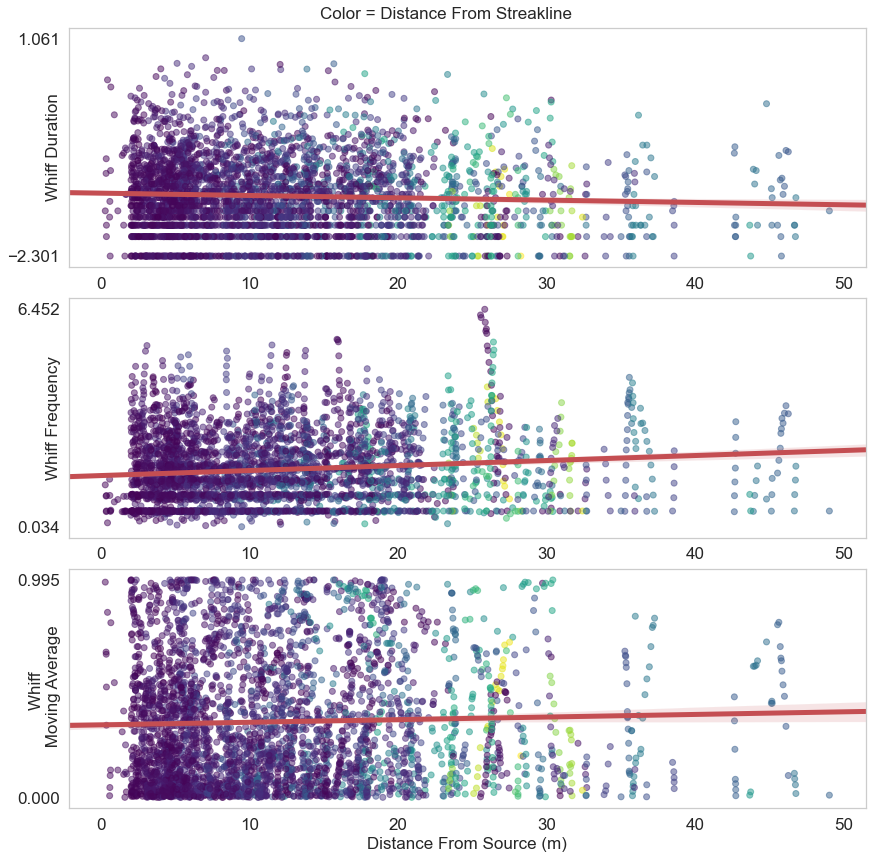

In [43]:
f,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(12,12))


ax1.scatter(fdf.avg_dist_from_source, fdf.log_whiff, c=fdf.avg_dist_from_streakline, cmap='viridis', alpha=0.5)
ax1.grid(False)
g1 =sns.regplot(x="avg_dist_from_source",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)
g1.set(xlabel=None)
# ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Whiff Duration')
ax1.set_yticks([fdf.log_whiff.min(),fdf.log_whiff.max()])
ax1.yaxis.set_label_coords(-0.01, 0.5)

ax2.scatter(fdf.avg_dist_from_source, fdf.mean_ef, c=fdf.avg_dist_from_streakline, cmap='viridis', alpha=0.5)
ax2.grid(False)
g2 = sns.regplot(x="avg_dist_from_source",y="mean_ef", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)
g2.set(xlabel=None)
# ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_yticks([fdf.mean_ef.min(),fdf.mean_ef.max()])
ax2.yaxis.set_label_coords(-0.01, 0.5)

ax3.scatter(fdf.avg_dist_from_source, fdf.mean_ma, c=fdf.avg_dist_from_streakline, cmap='viridis', alpha=0.5)
ax3.grid(False)
g3=sns.regplot(x="avg_dist_from_source",y="mean_ma", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)
g3.set(xlabel=None)
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Whiff \n Moving Average')
ax3.set_yticks([fdf.mean_ma.min(),fdf.mean_ma.max()])
ax3.yaxis.set_label_coords(-0.01, 0.5)

f.suptitle("Color = Distance From Streakline")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 17)

# f.savefig('../../Figure/NWStatScatter.jpeg', dpi=300, bbox_inches = "tight")

In [63]:
fdf = pd.read_hdf(dir+'ForestStats.h5')

In [65]:
# fdf = osm.sort_by_distance(fdf)

In [69]:
logwhiff=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
ef=smf.ols(formula=' avg_dist_from_source ~ mean_ef', data=fdf).fit()
ma=smf.ols(formula=' avg_dist_from_source ~ mean_ma', data=fdf).fit()
# logblank=smf.ols(formula=' avg_dist_from_source ~ log_blank', data=fdf).fit()

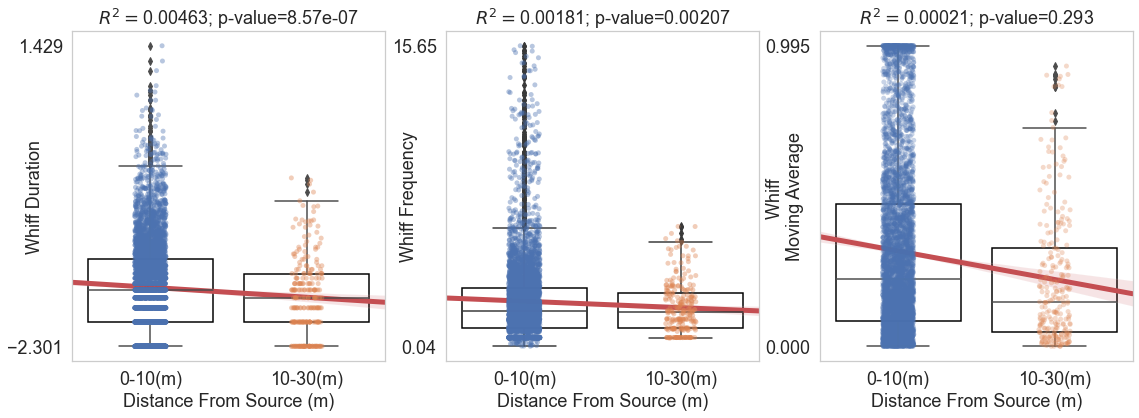

In [70]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6)
                    ,gridspec_kw={'width_ratios': [1,1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )
boxplotfill(ax1)

ax1.yaxis.set_label_coords(-0.09, 0.5)
ax2.yaxis.set_label_coords(-0.09, 0.5)
ax3.yaxis.set_label_coords(-0.05, 0.5)
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)
sns.regplot(x="bins_distance",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax1.grid(False)
ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Whiff Duration')
ax1.set_title('$R^2=$'+str(np.round(logwhiff.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logwhiff.pvalues.log_whiff)))
ax1.set_yticks([fdf.log_whiff.min(),fdf.log_whiff.max()])

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_ef", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    
sns.stripplot(x="distance_from_source_bin", y="mean_ef", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)
sns.regplot(x="bins_distance",y="mean_ef", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax2.grid(False)
ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_yticks([fdf.mean_ef.min(),fdf.mean_ef.max()])
ax2.set_title('$R^2=$'+str(np.round(ef.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(ef.pvalues.mean_ef)))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="mean_ma", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.grid(False)
ax3.set_yticks([fdf.mean_ma.min(),fdf.mean_ma.max()])
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Whiff \nMoving Average')
ax3.set_title('$R^2=$'+str(np.round(ma.rsquared,5)) 
            +'; p-value='+ str('{:.3g}'.format(ma.pvalues.mean_ma)))

# f.suptitle("Forest Odor Statistics")
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)

# f.savefig('../../Figure/MA_1_HWlog.jpeg', dpi=300)
# f.savefig('../../Figure/OdorStatForest.jpeg', dpi=300, bbox_inches = "tight")

In [64]:
encounter_freq=smf.ols(formula='mean_ef ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
encounters=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
# intermittencies=smf.ols(formula='log_blank ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
meanma = smf.ols(formula='mean_ma ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
# print(intermittencyfact.summary())

In [65]:
fdf['encounterfreq_resid']=encounter_freq.resid
fdf['encounter_resid'] = encounters.resid
# fdf['intermittency_resid'] = intermittencies.resid
fdf['meanma_resid'] = meanma.resid

In [66]:
# whiffresid=smf.ols(formula=' avg_dist_from_source ~ encounter_resid', data=fdf).fit()
# efresid=smf.ols(formula=' avg_dist_from_source ~ encounterfreq_resid', data=fdf).fit()
# maresid=smf.ols(formula=' avg_dist_from_source ~ intermittencyfact_resid', data=fdf).fit()
# logblankresid=smf.ols(formula=' avg_dist_from_source ~ intermittency_resid', data=fdf).fit()

In [68]:
distance=smf.ols(formula='avg_dist_from_source ~ encounterfreq_resid + encounter_resid + meanma_resid', data=fdf).fit()
print(distance.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     11.19
Date:                  Thu, 13 Jan 2022   Prob (F-statistic):           2.58e-07
Time:                          10:11:12   Log-Likelihood:                -12841.
No. Observations:                  5226   AIC:                         2.569e+04
Df Residuals:                      5222   BIC:                         2.572e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

In [69]:
distance=smf.ols(formula='avg_dist_from_source ~ mean_ef + log_whiff + mean_ma ', data=fdf).fit()
print(distance.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     10.34
Date:                  Thu, 13 Jan 2022   Prob (F-statistic):           8.82e-07
Time:                          10:11:59   Log-Likelihood:                -12842.
No. Observations:                  5226   AIC:                         2.569e+04
Df Residuals:                      5222   BIC:                         2.572e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8454      0.131

In [ ]:
# ## BootStrapping Results for Distance ~ Odor Statistics

# sns.set_style('whitegrid')
# f, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, figsize=(16,14))
# ax1.plot(rdf.angles,rdf.rsquared)
# ax1.set_yticks([rdf.rsquared.min(), rdf.rsquared.max()])
# ax1.set_ylabel('$R^2$', rotation = 0, color='blue')
# set_grid_false(ax1)
# ax1.yaxis.set_label_coords(-0.04,0.45)
# ax1.axes.get_xaxis().set_visible(False)

# ax2.plot(rdf.angles,rdf.p_whiff_length)
# ax2.set_yticks([rdf.p_whiff_length.min(), rdf.p_whiff_length.max()])
# ax2.set_ylabel('$p-value$\nWhiff Duration', rotation = 0, color='blue')
# set_grid_false(ax2)
# ax2.yaxis.set_label_coords(-0.08,0.4)
# ax2.axes.get_xaxis().set_visible(False)

# ax3.plot(rdf.angles, rdf.p_encounter_frequency)
# ax3.set_yticks([rdf.p_encounter_frequency.min(),rdf.p_encounter_frequency.max()])
# ax3.set_ylabel('$p-value$\nEncounter Frequency', rotation = 0, color='blue')
# set_grid_false(ax3)
# ax3.yaxis.set_label_coords(-0.1,0.4)
# ax3.axes.get_xaxis().set_visible(False)

# ax4.plot(rdf.angles, rdf.p_moving_avg)
# ax4.set_yticks([rdf.p_moving_avg.min(),rdf.p_moving_avg.max()])
# ax4.set_xticks([45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
# ax4.set_ylabel('$p-value$\nMoving Average', rotation = 0, color='blue')
# set_grid_false(ax4)
# ax4.yaxis.set_label_coords(-0.08,0.4)
# ax4.set_xlabel('Change in Direction', color='blue')

# f.suptitle('Wind Speed < 3m/s\nDistance ~ Odor-Statistics', fontsize='medium')
# f.tight_layout(pad=4)
# figurefirst.mpl_functions.set_fontsize(f, 18)
# # f.savefig('../../Figure/changeInDirNotWindy.jpeg', dpi=1000) 
# # f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)